In [1]:
import sys, os, csv
import numpy as np
import pandas as pd
import timeit
import pickle
import theano
import theano.tensor as T

os.chdir(sys.path[0] + "\..")

import yaml

from theano import shared, function
from scipy import stats
from datetime import datetime as dt

from reslogit.models import Logit, ResNet, MLP
from reslogit.core import *
import reslogit.optimizers as optimizers

In [2]:
# constants
FLOATX = theano.config.floatX

# read data file from .csv
raw_data = pd.read_csv(os.getcwd() + '/data/data-20190702_2.csv')

# read configuration file
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# keep track of time
config['timestamp'] = dt.now().strftime("%Y-%m-%d %H:%M:%S")

# defines the inputs and output
x_data = raw_data.iloc[:, 1:-1]
y_data = raw_data['mode']-1  # -1 for indexing at 0

# defines the list of explanatory variable names
config['variables'] = list(x_data.columns)

# number of observations
config['n_obs'] = raw_data.shape[0] 

# number of variables/choices
config['n_vars'] = x_data.shape[1]
config['n_choices'] = len(config['choices'])

# slicing index for train/valid split
slice = np.floor(0.7*config['n_obs']).astype(int)
config['slice'] = slice

# slices x and y datasets into train/valid
train_x_data, valid_x_data = x_data.iloc[:slice], x_data.iloc[slice:]
train_y_data, valid_y_data = y_data.iloc[:slice], y_data.iloc[slice:]

# load train/valid datasets into shared module
train_x_shared, train_y_shared = shared_dataset(train_x_data, train_y_data)
valid_x_shared, valid_y_shared = shared_dataset(valid_x_data, valid_y_data)

# number of train/valid batches
n_train_batches = train_y_data.shape[0] // config['batch_size']
n_valid_batches = valid_y_data.shape[0] // config['batch_size']
config['n_train_batches'] = n_train_batches
config['n_valid_batches'] = n_valid_batches

# Theano tensor variables
idx = T.lscalar()  # index to [mini]batch
# x = T.matrix('x')
# y = T.ivector('y')

disaggregate point elasticity: [0.44321127 0.36173554 0.72176339 ... 0.0903231  0.27432704 0.05659311]
aggregate point elasticity: 0.16871658272543483


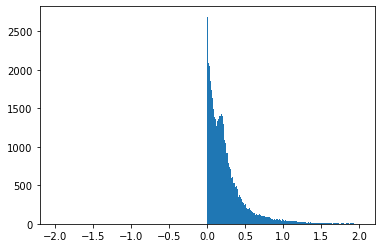

[(10, 0.06938737912868052), (15, 0.10021272579727793), (20, 0.12696104475195466), (25, 0.14907523141687687), (30, 0.16644398305454025), (35, 0.17931270439406827), (40, 0.18816772749003915), (45, 0.19362475829955986), (50, 0.19633584109027474), (55, 0.1969210865243905), (60, 0.19592659730057915), (65, 0.19380557594614503), (70, 0.19091718753998613), (75, 0.18753640306626193), (80, 0.18386824149075628), (85, 0.18006203153233172), (90, 0.17622376348272048), (95, 0.17242612775730876), (100, 0.16871658272543483), (105, 0.165123980570182), (110, 0.1616640613736073), (115, 0.15834384379062316), (120, 0.1551648772161679), (125, 0.15212545260443067), (130, 0.14922200750653233), (135, 0.14644999167054948), (140, 0.14380440200173533), (145, 0.14128011684795685), (150, 0.13887210142795656), (155, 0.1365755252574033), (160, 0.13438581865380703), (165, 0.13229868857395702), (170, 0.13031010908194388), (175, 0.12841629749489644), (180, 0.12661368386004732), (185, 0.12489887894792591), (190, 0.1232686

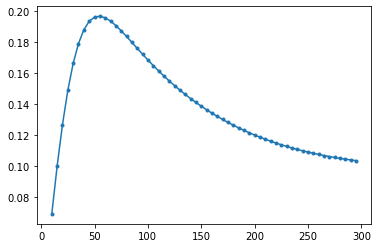

In [18]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 0

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [ 5.21324346  1.69844401  1.0282303  ... -0.0962727  -0.3280847
  0.0485399 ]
aggregate point elasticity: 0.28173498885414955


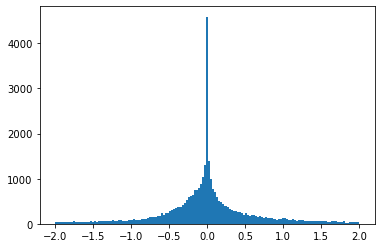

[(10, -0.03316978279435882), (15, -0.05836249592380908), (20, -0.09081040261368697), (25, -0.13178521117080066), (30, -0.18318831697448046), (35, -0.24526288143209204), (40, -0.31563062794294844), (45, -0.39340346183582786), (50, -0.4697576163965992), (55, -0.5223820503992465), (60, -0.5092732996247165), (65, -0.38144866520171533), (70, -0.09085077732841544), (75, 0.3520140458537623), (80, 0.747704810648045), (85, 0.931912777679241), (90, 0.8581512841320541), (95, 0.5374833419467605), (100, 0.2817349888541495), (105, 0.12706972576856132), (110, -0.1225326011773618), (115, -0.34296327978323027), (120, -0.4921541117252561), (125, -0.5886654193783972), (130, -0.6490217992580738), (135, -0.6872825790075529), (140, -0.7139057834963382), (145, -0.7428846734805493), (150, -0.7822989836758283), (155, -0.8345359027342085), (160, -0.9016511755542996), (165, -0.9745266940985006), (170, -1.0389659433211034), (175, -1.0868391181718509), (180, -1.1221214973750782), (185, -1.1096727968642235), (190, 

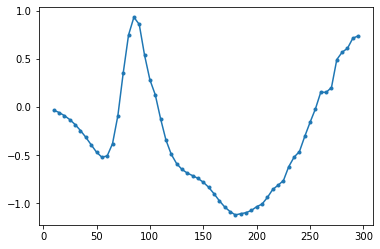

In [19]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 0

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2, 2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Biking elasticity profile (ResLogit)

disaggregate point elasticity: [-0.5774133  -1.89426919 -0.16503811 ... -1.77636548 -1.24098381
 -0.84250869]
aggregate point elasticity: -0.10759759827440268


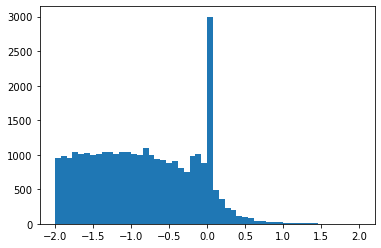

[(10, 0.0010691817328128987), (15, -0.003381578601330982), (20, -0.010692054112988549), (25, -0.020186712769909843), (30, -0.031066862160046723), (35, -0.042535653529857574), (40, -0.053895012584227464), (45, -0.06460132598467952), (50, -0.07428158036716423), (55, -0.08272009384745312), (60, -0.08982912017876325), (65, -0.09561485223037046), (70, -0.10014604609505198), (75, -0.10352857411557737), (80, -0.10588661189093644), (85, -0.10734975907340463), (90, -0.10804485721125064), (95, -0.1080911516456022), (100, -0.10759759827440268), (105, -0.10666150781517122), (110, -0.10536811802989171), (115, -0.10379088099007118), (120, -0.10199227345206012), (125, -0.10002491719535007), (130, -0.09793281243690784), (135, -0.09575254292748399), (140, -0.09351437587823196), (145, -0.09124322933723894), (150, -0.08895950738783914), (155, -0.08667981484210667), (160, -0.08441756587729295), (165, -0.08218350067071967), (170, -0.07998612283249851), (175, -0.07783206899088929), (180, -0.0757264204462196

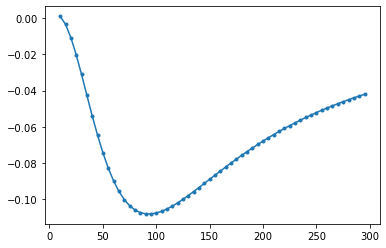

In [20]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 1

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Biking elasticity profile (ResLogit)

disaggregate point elasticity: [ -3.94202742 -27.65894672   0.2870916  ...  -5.60750754  -6.32242448
  -3.92456661]
aggregate point elasticity: -0.6193844078276267


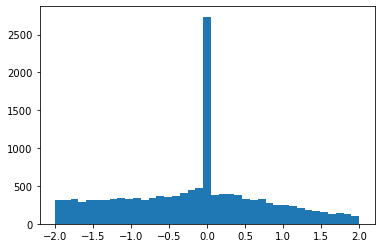

[(10, 0.013746798184873616), (15, 0.024510706420079024), (20, 0.039483481421657494), (25, 0.06072204167101979), (30, 0.09078138956072791), (35, 0.13215725020798705), (40, 0.18531921989499392), (45, 0.2531831274722667), (50, 0.3303676427416305), (55, 0.40237195670010073), (60, 0.4331128483812452), (65, 0.3674767289398803), (70, 0.13591213733498986), (75, -0.3087272248887395), (80, -0.7935836863796196), (85, -1.0918541716713381), (90, -1.0860347121091005), (95, -0.8016590554208315), (100, -0.6193844078276266), (105, -0.5324468954891406), (110, -0.3201908561109843), (115, -0.17277234863477883), (120, -0.10318935747121483), (125, -0.07021046769111912), (130, -0.05347136730619944), (135, -0.04465771043878067), (140, -0.04172078104856849), (145, -0.0393768836072385), (150, -0.03826257092816975), (155, -0.03804270853734245), (160, -0.03812852190494648), (165, -0.03815302116402911), (170, -0.03799985636668598), (175, -0.03758930009417926), (180, -0.03594032451782647), (185, -0.0341066033507197

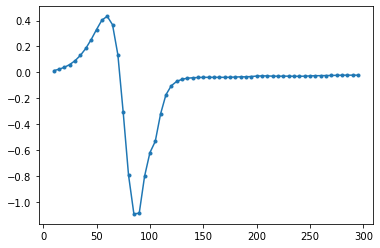

In [21]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 1

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Transit elasticity profile (MNL)

disaggregate point elasticity: [ 0.38228234  0.22705727  0.66882339 ... -0.0211139   0.18386648
  0.0029188 ]
aggregate point elasticity: 0.08412625875737008


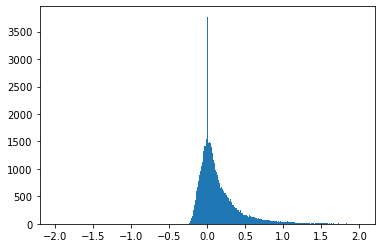

[(10, 0.02647383794688745), (15, 0.03946138440244867), (20, 0.05164517315024654), (25, 0.06263787912295717), (30, 0.072166844786426), (35, 0.08008611098253955), (40, 0.0863690218080939), (45, 0.09108553003496522), (50, 0.09437121427530677), (55, 0.09639669707538377), (60, 0.09734383908555835), (65, 0.09739046225693031), (70, 0.09670193474775764), (75, 0.09542687023997441), (80, 0.09369506419732097), (85, 0.09161692814572245), (90, 0.08928378835894306), (95, 0.0867684603195844), (100, 0.08412625875737008), (105, 0.08139704307284629), (110, 0.0786083866043998), (115, 0.07577921600408302), (120, 0.07292306611458513), (125, 0.07005043132252052), (130, 0.06717015580787963), (135, 0.06429009415325022), (140, 0.061417340325942), (145, 0.058558258185063314), (150, 0.05571845216780254), (155, 0.05290274479616014), (160, 0.05011518551567732), (165, 0.047359093362368765), (170, 0.044637125275446374), (175, 0.041951358198962875), (180, 0.0393033740096082), (185, 0.036694339526111654), (190, 0.0341

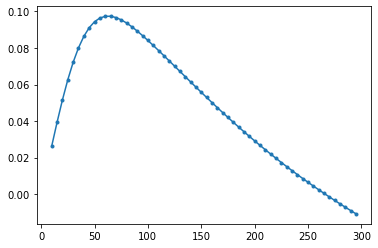

In [22]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 2

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Transit elasticity profile (ResLogit)

disaggregate point elasticity: [ 1.23072117 -3.21580494  1.79645551 ...  1.51276954  0.66931398
  0.22346196]
aggregate point elasticity: 0.3038443355724595


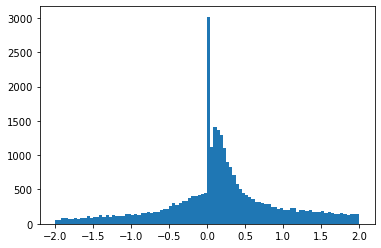

[(10, 0.01810211035997991), (15, 0.03065802036856037), (20, 0.045803499602277704), (25, 0.06341611152708092), (30, 0.0831161511795494), (35, 0.10411338612344968), (40, 0.12521409104458583), (45, 0.14395568188194527), (50, 0.15745823770799236), (55, 0.16002203526049358), (60, 0.14387911554210825), (65, 0.10886452811427272), (70, 0.06657216447551736), (75, 0.057895568927522574), (80, 0.11473188220674028), (85, 0.19355599726430103), (90, 0.23169232873241571), (95, 0.2480624346840854), (100, 0.30384433557245943), (105, 0.35622400725732467), (110, 0.3901797423767268), (115, 0.4654621487407726), (120, 0.5551745446023288), (125, 0.6373918751640957), (130, 0.7067081009403611), (135, 0.7627719711617811), (140, 0.815503341858196), (145, 0.871179112150612), (150, 0.9367792024892037), (155, 1.008175980300248), (160, 1.0908303403985828), (165, 1.1693620783429435), (170, 1.2586882702984192), (175, 1.3202233786272262), (180, 1.355347785695482), (185, 1.3552972663942116), (190, 1.330837166015136), (19

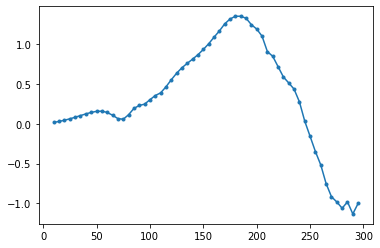

In [23]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 2

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Walking elasticity profile (MNL)

disaggregate point elasticity: [-2.29176668 -5.68370306 -1.65460753 ... -4.91186108 -3.78626671
 -2.35273902]
aggregate point elasticity: -0.13806143840006532


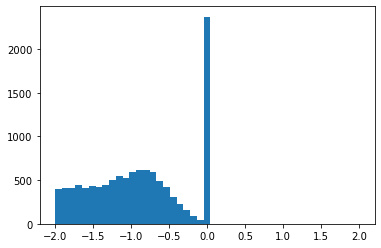

[(10, -0.10360510251186096), (15, -0.14550189941891328), (20, -0.17897121153512818), (25, -0.20370726888408439), (30, -0.22014879740526005), (35, -0.22926395470738117), (40, -0.23231227504655916), (45, -0.23063705063969084), (50, -0.2255109679193755), (55, -0.21804113498842218), (60, -0.20912787013199), (65, -0.19946342657590196), (70, -0.18955506354633714), (75, -0.17975836866470626), (80, -0.17031069612463365), (85, -0.16135987679002792), (90, -0.15298684165315152), (95, -0.14522260968677897), (100, -0.13806143840006532), (105, -0.1314721228830771), (110, -0.12540821966053017), (115, -0.11981670647997268), (120, -0.1146443329171116), (125, -0.10984146909849186), (130, -0.1053638874506802), (135, -0.10117318356782952), (140, -0.09723647039019472), (145, -0.09352576710555617), (150, -0.09001731097293303), (155, -0.0866908997056901), (160, -0.08352930970503686), (165, -0.08051780356960618), (170, -0.07764372277197225), (175, -0.07489615279169388), (180, -0.0722656461105771), (185, -0.06

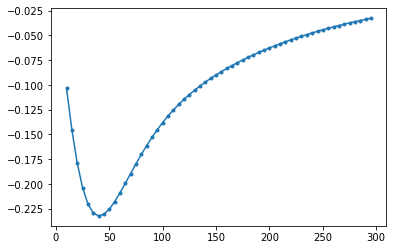

In [24]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 3

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Walking elasticity profile (ResLogit)

disaggregate point elasticity: [ -3.44002333 -15.33393154  -4.50925149 ...  -0.07898129  -1.9233613
  -1.24421557]
aggregate point elasticity: -0.07327410953141883


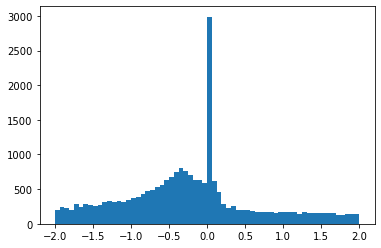

[(10, -0.004435490486991937), (15, -0.0061291439770815356), (20, -0.007589984172989016), (25, -0.00910865714286656), (30, -0.010390551919759218), (35, -0.012200556000975275), (40, -0.015346497728259691), (45, -0.019884295323269442), (50, -0.024986793132473057), (55, -0.03162171032595694), (60, -0.03894052631161822), (65, -0.04666444271595938), (70, -0.05482403787443897), (75, -0.06134088381543353), (80, -0.067576852590509), (85, -0.0706943220157924), (90, -0.07286383446512364), (95, -0.073023974968876), (100, -0.07327410953141883), (105, -0.0739672867986423), (110, -0.07420084138842332), (115, -0.07344086445314815), (120, -0.07233226596336323), (125, -0.07077118470701949), (130, -0.06908152669716425), (135, -0.06418820943433984), (140, -0.060500946176403135), (145, -0.057605721633797694), (150, -0.055063565126371616), (155, -0.04729621219623386), (160, -0.0386130664573788), (165, -0.023429799811829796), (170, -0.031352226896601096), (175, -0.03232998362545465), (180, -0.024876283549346

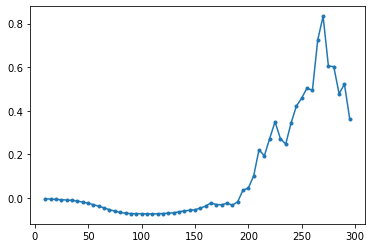

In [25]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 3

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Auto+Transit elasticity profile (MNL)

disaggregate point elasticity: [0.46273673 0.40489491 0.73872869 ... 0.12603451 0.30331629 0.07379372]
aggregate point elasticity: 0.00965636372506017


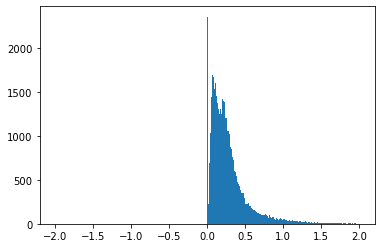

[(10, 0.0027355375989567415), (15, 0.004122116125823086), (20, 0.0054310853965728895), (25, 0.006607237350933202), (30, 0.0076140218922016115), (35, 0.00843546998744972), (40, 0.009073727617399453), (45, 0.009544045745853783), (50, 0.009869171997793778), (55, 0.01007451920786999), (60, 0.010184776285106079), (65, 0.01022204276161016), (70, 0.010205179771401493), (75, 0.010149856039347706), (80, 0.010068815411629399), (85, 0.009972158775442986), (90, 0.009867641015271352), (95, 0.009761008789441566), (100, 0.00965636372506017), (105, 0.00955652056032575), (110, 0.00946333423413857), (115, 0.009377976384726846), (120, 0.009301150385221372), (125, 0.009233245283150771), (130, 0.009174438533314892), (135, 0.009124761715190931), (140, 0.009084142559708271), (145, 0.009052433019943936), (150, 0.009029429330793842), (155, 0.00901488727998759), (160, 0.009008534342239092), (165, 0.009010079519734607), (170, 0.00901922133187181), (175, 0.009035654211593322), (180, 0.009059073498807326), (185, 0

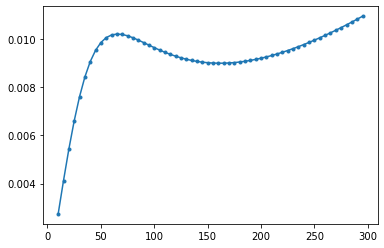

In [26]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 4

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

# Auto+Transit elasticity profile (ResLogit)

disaggregate point elasticity: [2.53474098 3.3057498  2.22553026 ... 1.35042919 2.53858242 0.15527193]
aggregate point elasticity: 0.07948555262658352


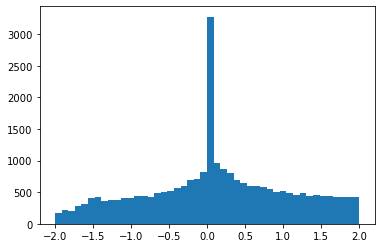

[(10, 0.0030179379168225177), (15, 0.004997972643821274), (20, 0.007104587692384567), (25, 0.009052242936575208), (30, 0.010414102065544883), (35, 0.01063675385193602), (40, 0.009046275462034256), (45, 0.0047661466225878855), (50, -0.0029332262136818063), (55, -0.014222485270564581), (60, -0.027465041000646107), (65, -0.03763848832700737), (70, -0.03807553129045546), (75, -0.022107261221023727), (80, 0.004167332245783193), (85, 0.027368352045284438), (90, 0.046647207130221434), (95, 0.062352352541006476), (100, 0.07948555262658352), (105, 0.0963075629063261), (110, 0.10520067183402716), (115, 0.10834347872975336), (120, 0.10393684898065551), (125, 0.09132635083159826), (130, 0.07207310683445738), (135, 0.048652206420300985), (140, 0.023513491139032557), (145, -0.0015616561462139058), (150, -0.02538557537283384), (155, -0.04731922050468474), (160, -0.06695291293826186), (165, -0.08390993420246358), (170, -0.09780478301978376), (175, -0.10834461878992893), (180, -0.11543686628289102), (1

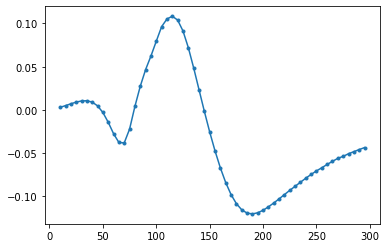

In [27]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 4

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 10].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 10] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)

plt.hist(point_elasticity, bins='auto', range=(-2,2))
plt.show()

list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 10].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 10] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()